Notebook to experiment with plotting and interpolation of GIOPS outpt

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy.interpolate as interp

%matplotlib inline

In [2]:
fname = '/data/hdd/giops/daily/201607/giops_2016072100_024.nc'
f = nc.Dataset(fname)
jss,jee = 0,1021
iss,iee = 0,1442

temp = f.variables['votemper'][0,0,jss:jee,iss:iee]
lon = f.variables['nav_lon'][jss:jee,iss:iee]
lon=lon.data
lat = f.variables['nav_lat'][jss:jee,iss:iee]

Simple pcolormesh, no processing

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,u'Pcolormesh - no interpolation')

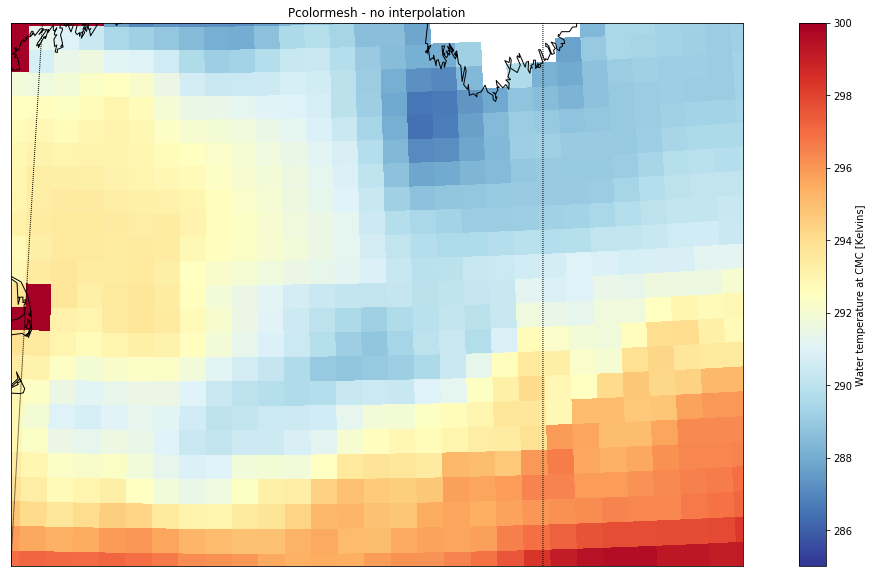

In [3]:
fig_orig,ax=plt.subplots(1,1,figsize=(20,10))
llcrlon,llcrlat,urcrlon,urcrlat=-70,40,-63,44
bmap = Basemap(llcrnrlon=llcrlon,llcrnrlat=llcrlat,urcrnrlon=urcrlon,urcrnrlat=urcrlat,
            resolution='i',projection='cass',lon_0=-65,lat_0=42,ax=ax)
bmap.drawmeridians(np.arange(llcrlon,urcrlon,5.))
bmap.drawparallels(np.arange(llcrlat,urcrlat,5.))
bmap.drawcoastlines()
x,y=bmap(lon, lat)
mesh=bmap.pcolormesh(x,y,temp,vmin=285,vmax=300,cmap='RdYlBu_r')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('{} [{}]'.format(f.variables['votemper'].long_name,
                                f.variables['votemper'].units))
ax.set_title('Pcolormesh - no interpolation')

Why are some of the land cells showing up as red?

What does the mask look like?

Text(0.5,1,u'Temperature mask')

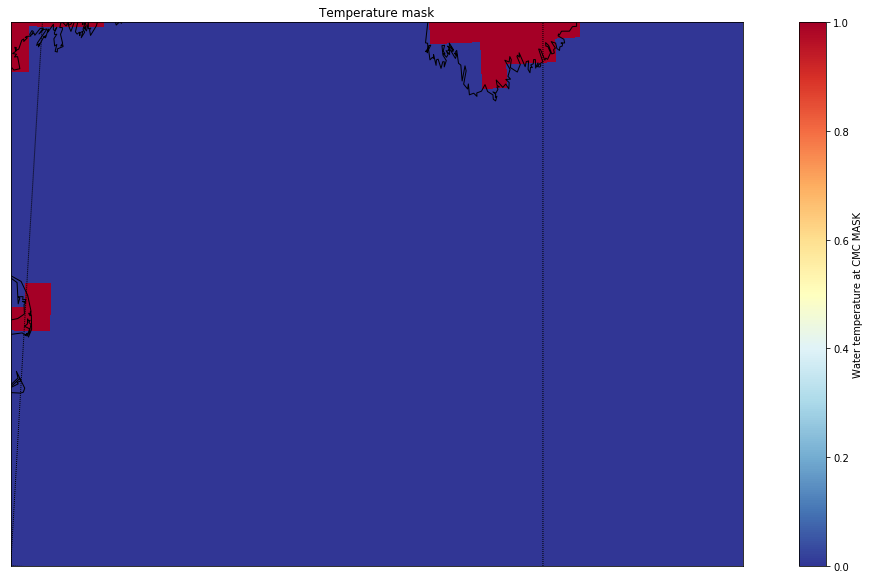

In [4]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
llcrlon,llcrlat,urcrlon,urcrlat=-70,40,-63,44
bmap = Basemap(llcrnrlon=llcrlon,llcrnrlat=llcrlat,urcrnrlon=urcrlon,urcrnrlat=urcrlat,
            resolution='i',projection='cass',lon_0=-65,lat_0=42,ax=ax)
bmap.drawmeridians(np.arange(llcrlon,urcrlon,5.))
bmap.drawparallels(np.arange(llcrlat,urcrlat,5.))
bmap.drawcoastlines()
x,y=bmap(lon, lat)
mesh=ax.pcolormesh(x,y,temp.mask==1,cmap='RdYlBu_r')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('{} MASK'.format(f.variables['votemper'].long_name))
ax.set_title('Temperature mask')

How do contours look?

Text(0.5,1,u'Contour plot')

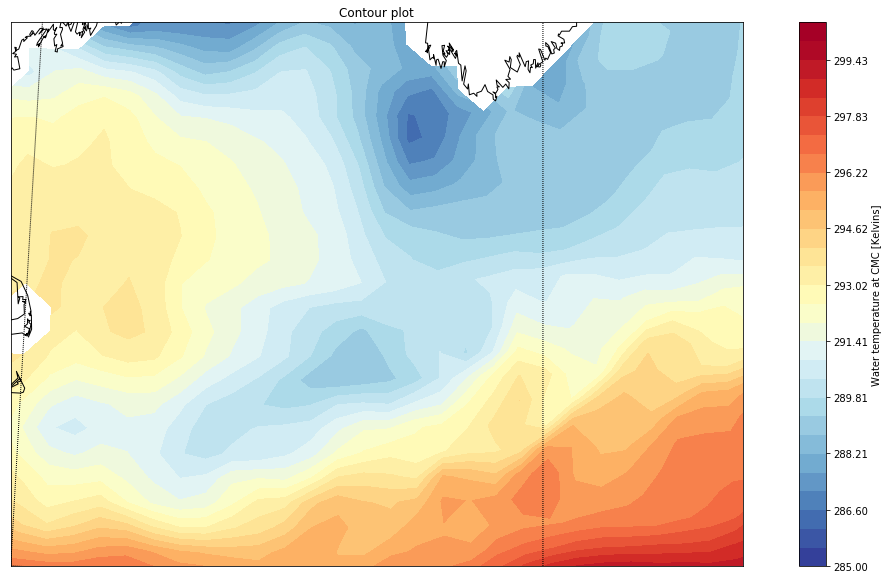

In [5]:
fig_cont,ax=plt.subplots(1,1,figsize=(20,10))
llcrlon,llcrlat,urcrlon,urcrlat=-70,40,-63,44
bmap = Basemap(llcrnrlon=llcrlon,llcrnrlat=llcrlat,urcrnrlon=urcrlon,urcrnrlat=urcrlat,
            resolution='i',projection='cass',lon_0=-65,lat_0=42,ax=ax)
bmap.drawmeridians(np.arange(llcrlon,urcrlon,5.))
bmap.drawparallels(np.arange(llcrlat,urcrlat,5.))
bmap.drawcoastlines()
x,y=bmap(lon, lat)
levels=np.linspace(285,300.5,30)
mesh=ax.contourf(x,y,temp,levels,vmin=285,vmax=300,cmap='RdYlBu_r')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('{} [{}]'.format(f.variables['votemper'].long_name,
                                f.variables['votemper'].units))
ax.set_title('Contour plot')

# Navigator Interpolation

The navigator interpolation uses a package desinged for interpolating satellite data
* http://pyresample.readthedocs.io/en/latest/index.html

It can handle gridded satellite data, so why not gridded ocean model data?

I **think** that the navigator uses imshow to render the images (see map.py). imshow has built in interpolation features. Lets experiment

In [6]:
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_custom, resample_nearest

In [7]:
def resample(in_lat, in_lon, out_lat, out_lon, data, method='inv_square',
             neighbours=10, radius_of_influence=25000, nprocs=1):
    masked_lat = in_lat.view(np.ma.MaskedArray)
    masked_lon = in_lon.view(np.ma.MaskedArray)
    masked_lon.mask = masked_lat.mask = data.view(np.ma.MaskedArray).mask

    input_def = SwathDefinition(lons=masked_lon, lats=masked_lat)
    target_def = SwathDefinition(lons=out_lon, lats=out_lat)

    if method == 'inv_square':
        res = resample_custom(
            input_def,
            data,
            target_def,
            radius_of_influence=radius_of_influence,
            neighbours=neighbours,
            weight_funcs=lambda r: 1 / np.clip(r, 0.0625,
                                               np.finfo(r.dtype).max) ** 2,
            fill_value=None,
            nprocs=nprocs)
    elif method == 'bilinear':
        res = resample_custom(
            input_def,
            data,
            target_def,
            radius_of_influence=radius_of_influence,
            neighbours=4,
            weight_funcs=lambda r: 1 / np.clip(r, 0.0625,
                                               np.finfo(r.dtype).max),
            fill_value=None,
            nprocs=nprocs)
    elif method == 'nn':
        res = resample_nearest(
            input_def,
            data,
            target_def,
            radius_of_influence=radius_of_influence,
            fill_value=None,
            nprocs=nprocs)
    else:
        raise ValueError("Unknown resample method: %s", method)

    if type(res.mask) == bool:
        res.mask = np.tile(res.mask, len(res))
    return res

In [8]:
n,radius,neighbours, method=50,25000,10,'inv_square'
lonsi = np.linspace(llcrlon,urcrlon,num=n)
latsi = np.linspace(llcrlat,urcrlat,num=50)

lonsi, latsi = np.meshgrid(lonsi, latsi)
res = resample(lat,lon, latsi, lonsi, temp,radius_of_influence=radius, method=method,neighbours=10)

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/pyresample/geometry.py:96: UserWarning: All geometry objects expect longitudes in the [-180:+180[ range. We will now automatically wrap your longitudes into [-180:+180[, and continue. To avoid this warning next time, use routine utils.wrap_longitudes().
  'To avoid this warning next time, use routine utils.wrap_longitudes().')


/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,u'Imshow Bilinear, Ocean Navigator interpolation- 50x50, r=25000m, method=inv_square, neighs=10')

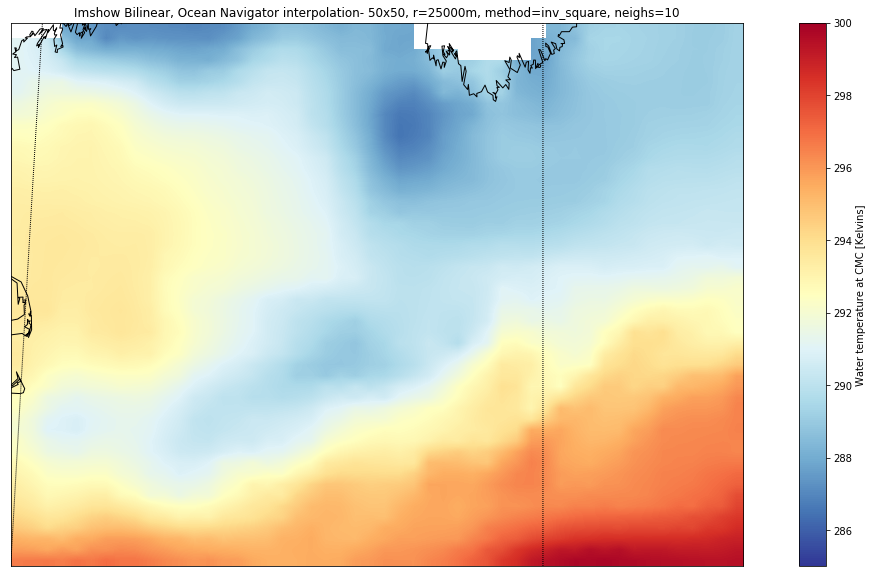

In [9]:
fig_ocnnav_imshow,ax=plt.subplots(1,1,figsize=(20,10))
llcrlon,llcrlat,urcrlon,urcrlat=-70,40,-63,44
bmap = Basemap(llcrnrlon=llcrlon,llcrnrlat=llcrlat,urcrnrlon=urcrlon,urcrnrlat=urcrlat,
                resolution='i',projection='cass',lon_0=-65,lat_0=42,ax=ax)
bmap.drawmeridians(np.arange(llcrlon,urcrlon,5.))
bmap.drawparallels(np.arange(llcrlat,urcrlat,5.))
bmap.drawcoastlines()
x,y=bmap(lonsi, latsi)
mesh=bmap.imshow(res,vmin=285,vmax=300,cmap='RdYlBu_r', interpolation='bilinear')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('{} [{}]'.format(f.variables['votemper'].long_name,
                                f.variables['votemper'].units))
title=('Imshow Bilinear, Ocean Navigator interpolation'
       '- {}x{}, r={}m, method={}, neighs={}'.format(n,n,radius,method,neighbours))
ax.set_title(title)

Text(0.5,1,u'Pcolormesh Ocean Navigator interpolation- 50x50, r=25000m, method=inv_square, neighs=10')

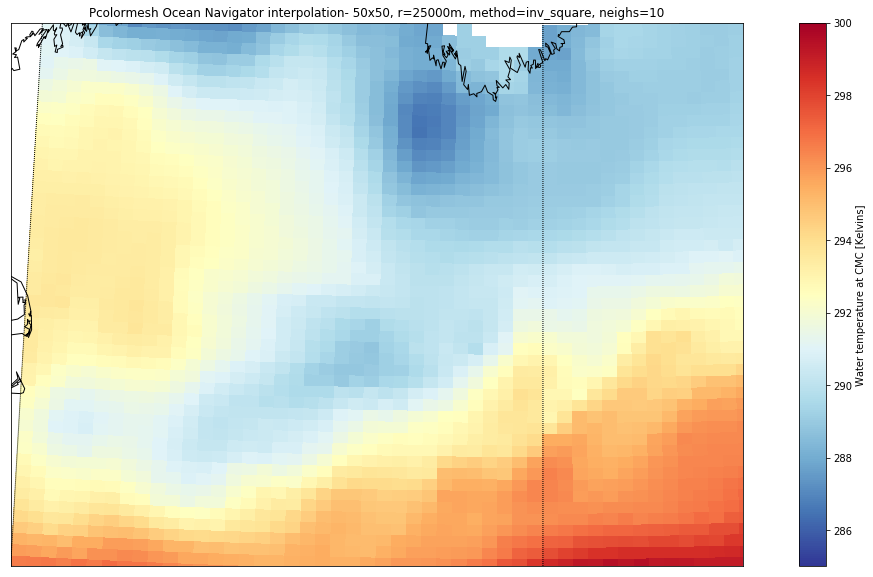

In [10]:
fig_ocnnav_pcolormesh,ax=plt.subplots(1,1,figsize=(20,10))
llcrlon,llcrlat,urcrlon,urcrlat=-70,40,-63,44
bmap = Basemap(llcrnrlon=llcrlon,llcrnrlat=llcrlat,urcrnrlon=urcrlon,urcrnrlat=urcrlat,
                resolution='i',projection='cass',lon_0=-65,lat_0=42,ax=ax)
bmap.drawmeridians(np.arange(llcrlon,urcrlon,5.))
bmap.drawparallels(np.arange(llcrlat,urcrlat,5.))
bmap.drawcoastlines()
x,y=bmap(lonsi, latsi)
ax.pcolormesh(x,y,res,vmin=285,vmax=300,cmap='RdYlBu_r')
cbar=plt.colorbar(mesh, ax=ax)
cbar.set_label('{} [{}]'.format(f.variables['votemper'].long_name,
                                f.variables['votemper'].units))
title=('Pcolormesh Ocean Navigator interpolation'
       '- {}x{}, r={}m, method={}, neighs={}'.format(n,n,radius,method,neighbours))
ax.set_title(title)

Imshow with bilinear inteprolation is smoother than pcolormesh which looks gridded.

Next, use pcolormesh to determine impact of radius, neighbours, grid size etc on image

## 1. Grid size

Inverse square with neighbours=10, radius=25km

In [11]:
def plot(field, lon, lat,title):
    fig,ax=plt.subplots(1,1,figsize=(20,10))
    llcrlon,llcrlat,urcrlon,urcrlat=-70,40,-63,44
    bmap = Basemap(llcrnrlon=llcrlon,llcrnrlat=llcrlat,urcrnrlon=urcrlon,urcrnrlat=urcrlat,
                resolution='i',projection='cass',lon_0=-65,lat_0=42,ax=ax)
    bmap.drawmeridians(np.arange(llcrlon,urcrlon,5.))
    bmap.drawparallels(np.arange(llcrlat,urcrlat,5.))
    bmap.drawcoastlines()
    x,y=bmap(lon, lat)
    mesh=ax.pcolormesh(x,y,field,vmin=285,vmax=300,cmap='RdYlBu_r')
    cbar=plt.colorbar(mesh, ax=ax)
    cbar.set_label('{} [{}]'.format(f.variables['votemper'].long_name,
                                    f.variables['votemper'].units))
    ax.set_title(title)
    return fig

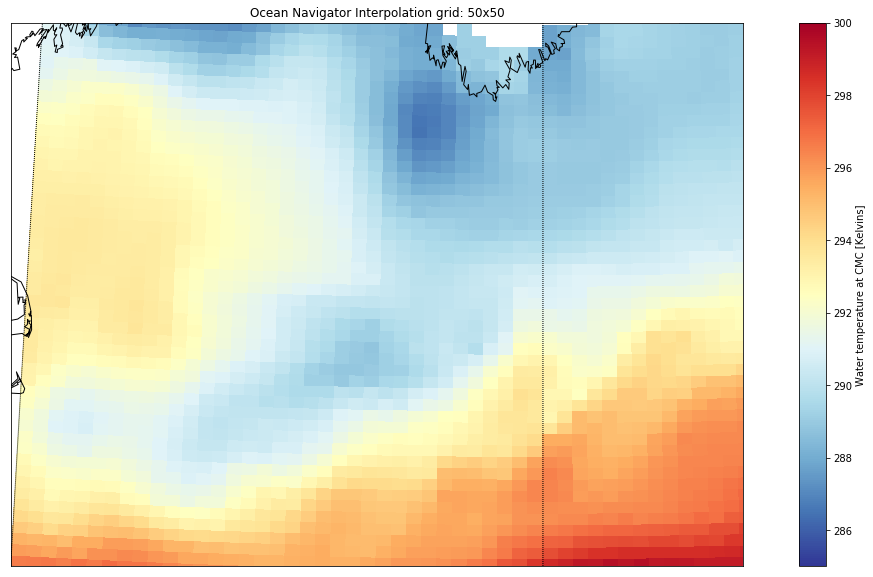

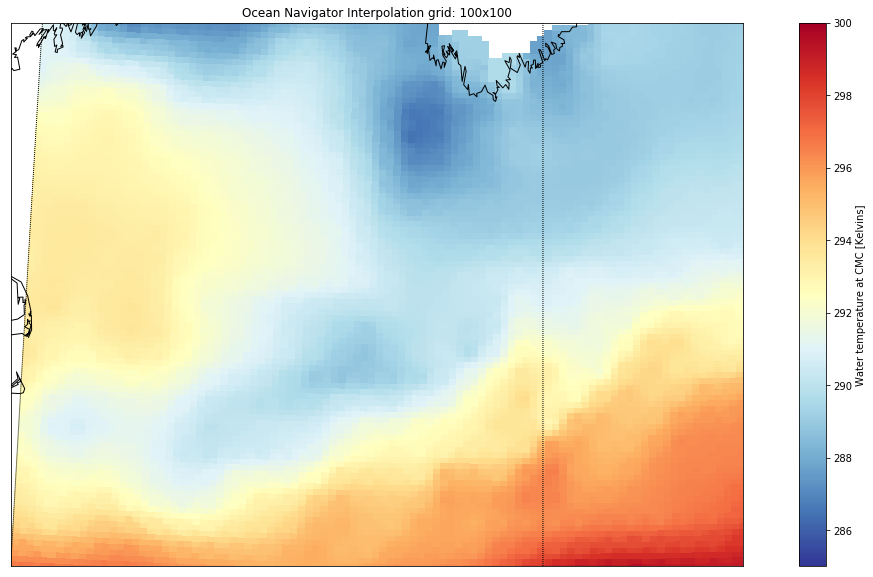

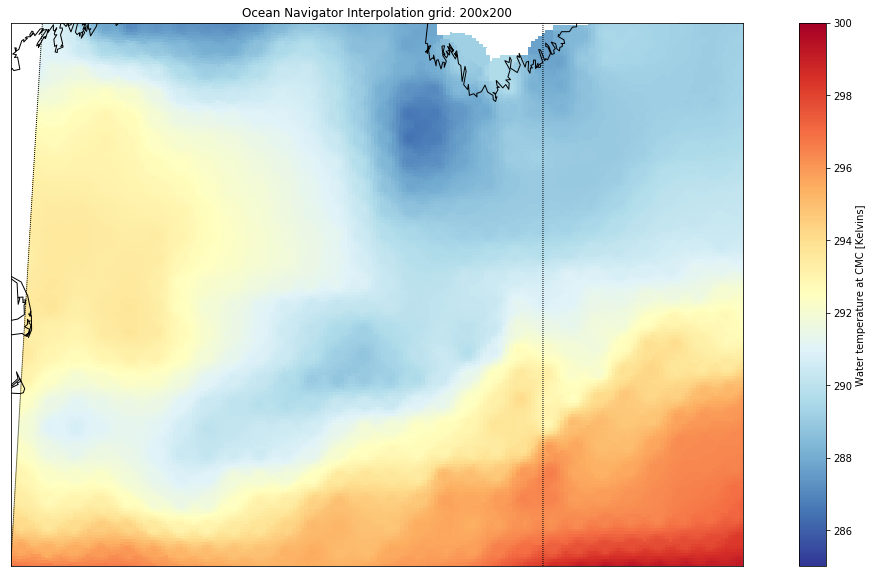

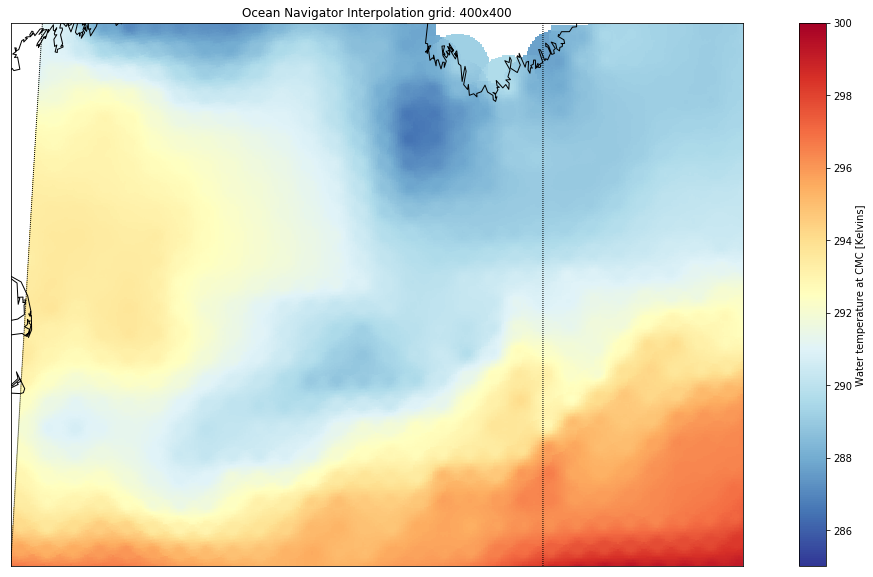

In [12]:
ns = [50,100, 200, 400]
for n in ns:
    lonsi = np.linspace(llcrlon,urcrlon,num=n)
    latsi = np.linspace(llcrlat,urcrlat,num=n)

    lonsi, latsi = np.meshgrid(lonsi, latsi)
    res = resample(lat,lon, latsi, lonsi, temp)
    title = 'Ocean Navigator Interpolation grid: {}x{}'.format(n,n)
    fig = plot(res, lonsi, latsi, title)

Smaller grids = gridded look, larger grids - circles

## 2. Radius

200x200 grid, neighbours=10, method=inv_square


/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/pyresample/kd_tree.py:393: UserWarning: Possible more than 10 neighbours within 50000 m for some data points
  (neighbours, radius_of_influence))


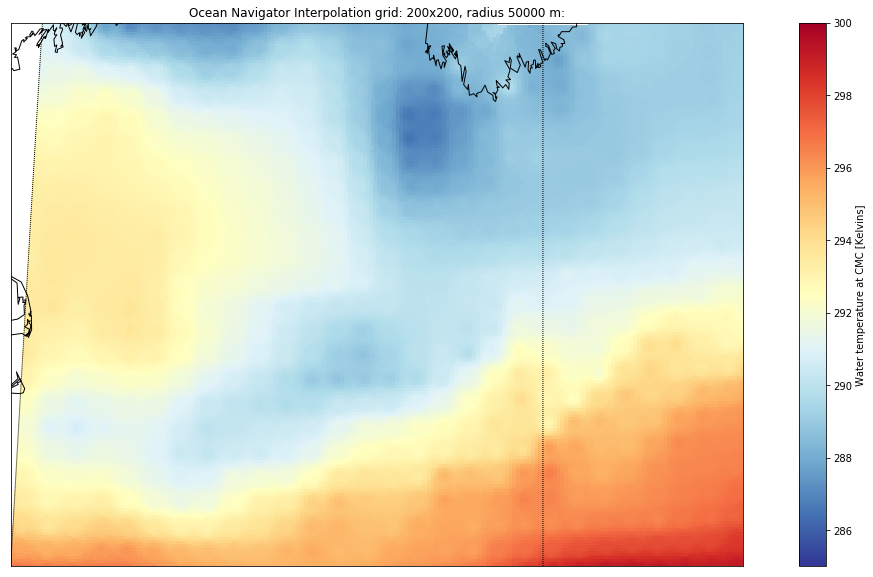

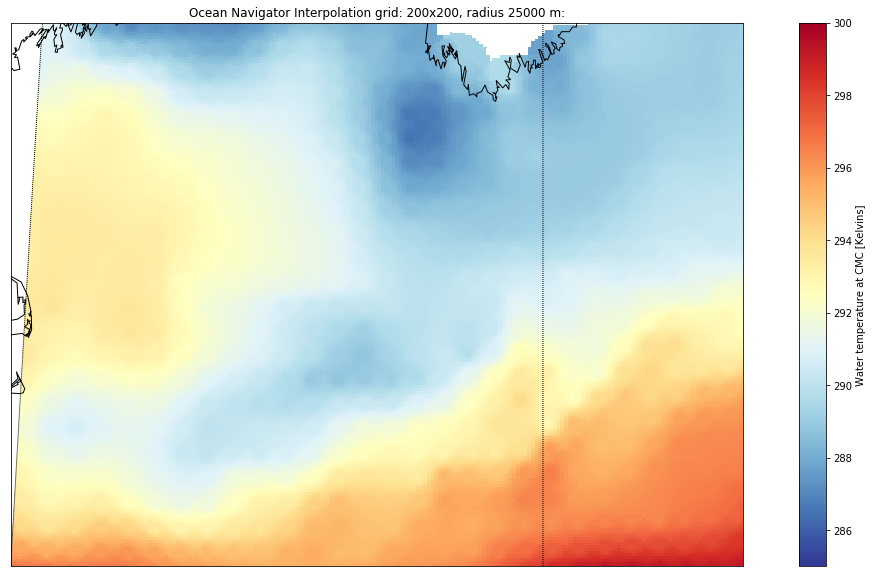

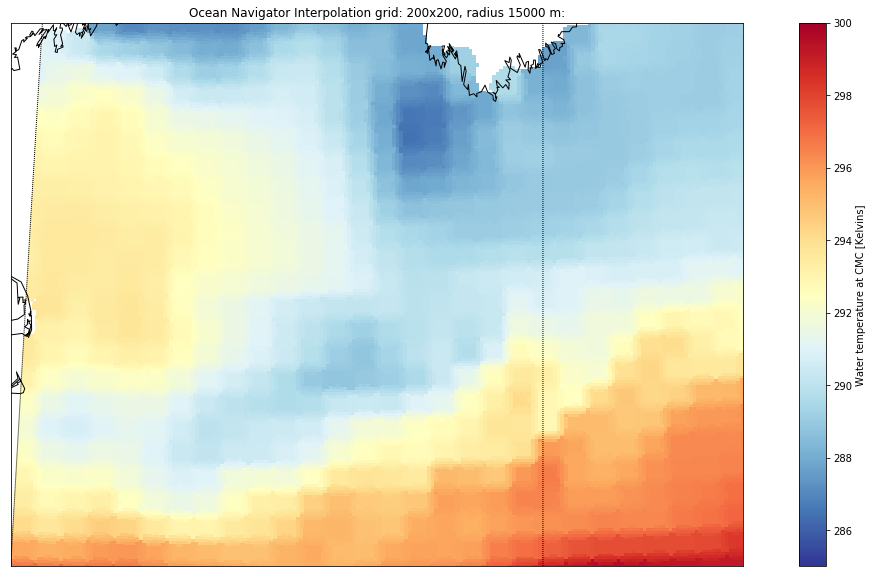

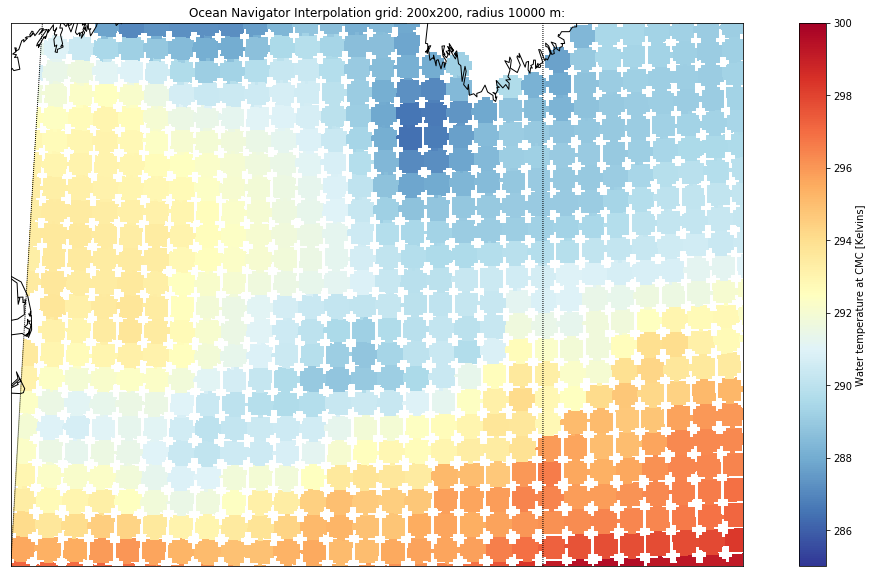

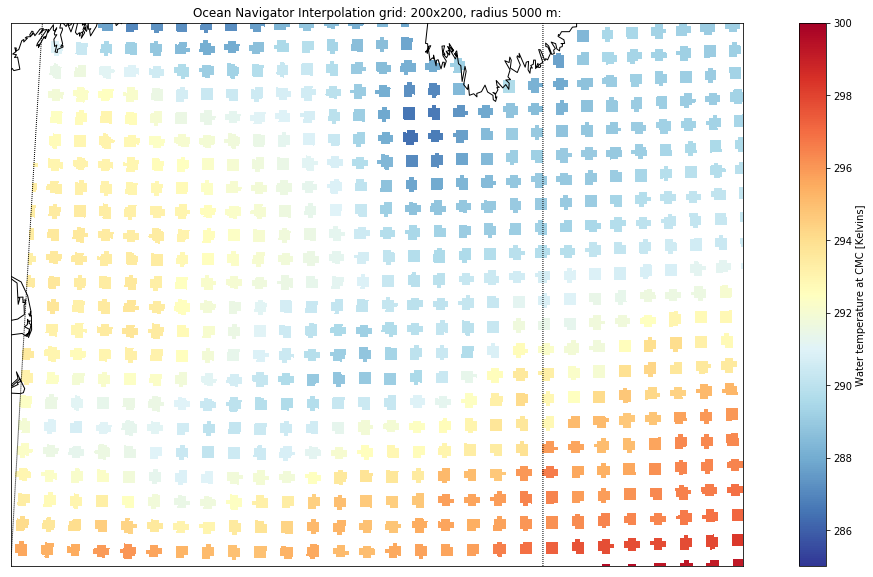

In [13]:
n=200
radii = [50000, 25000, 15000, 10000, 5000]

lonsi = np.linspace(llcrlon,urcrlon,num=n)
latsi = np.linspace(llcrlat,urcrlat,num=n)
lonsi, latsi = np.meshgrid(lonsi, latsi)
for r in radii:
    res = resample(lat,lon, latsi, lonsi, temp, radius_of_influence=r,)
    title = 'Ocean Navigator Interpolation grid: {}x{}, radius {} m:'.format(n,n, r)
    fig = plot(res, lonsi, latsi, title)

Smaller radius = not enough overlap

## 3. Number of neighbours

200x200grid, 25000m radius, method inv_square

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/pyresample/kd_tree.py:393: UserWarning: Possible more than 5 neighbours within 25000 m for some data points
  (neighbours, radius_of_influence))


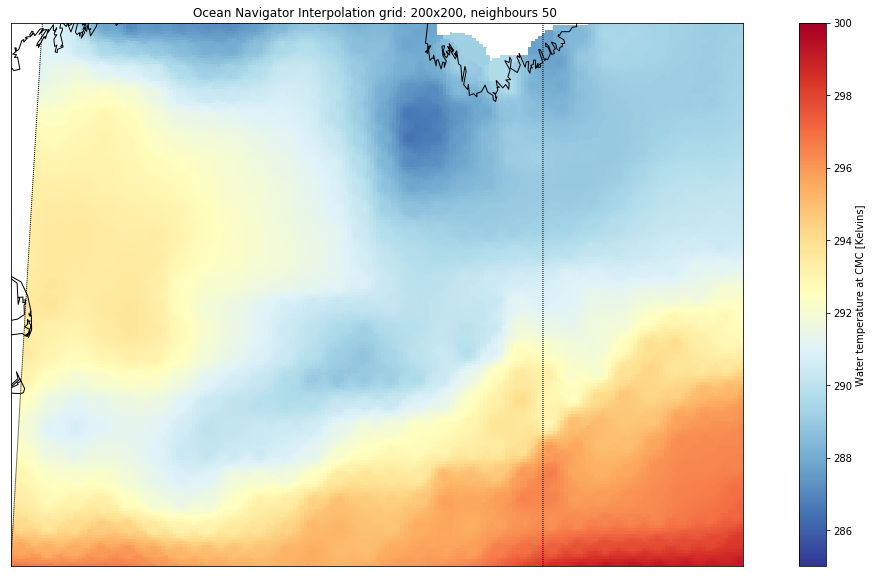

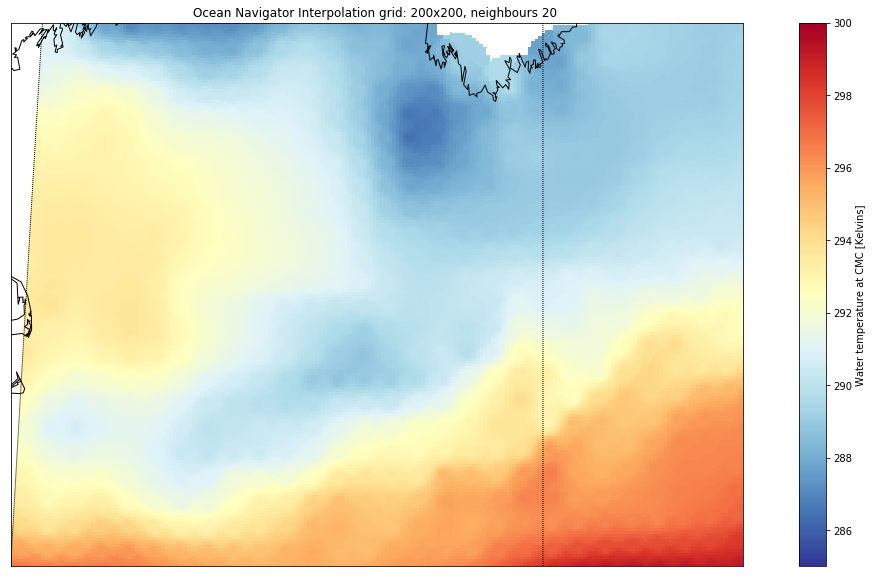

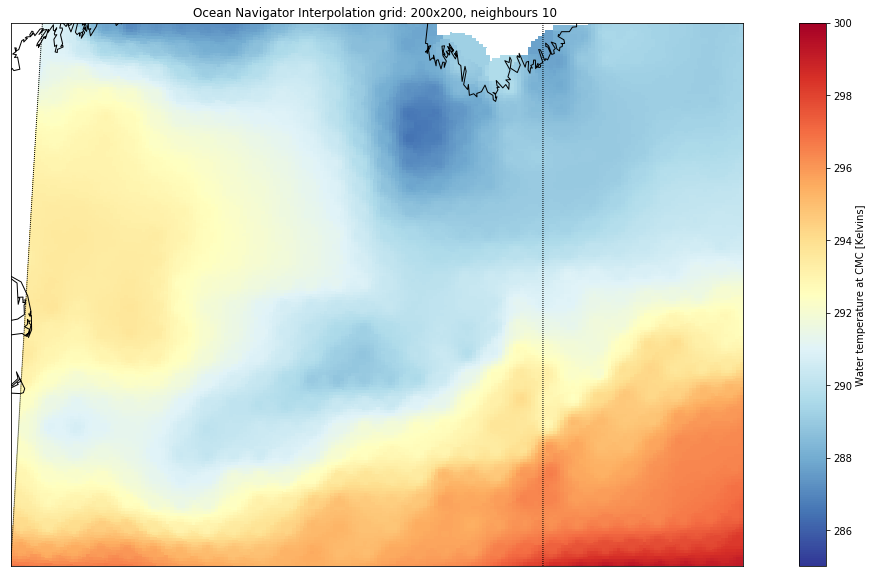

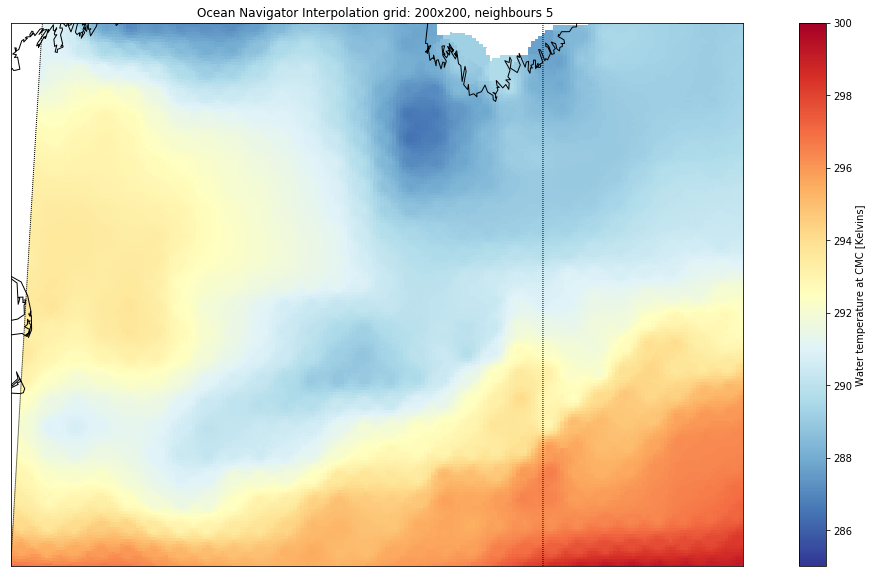

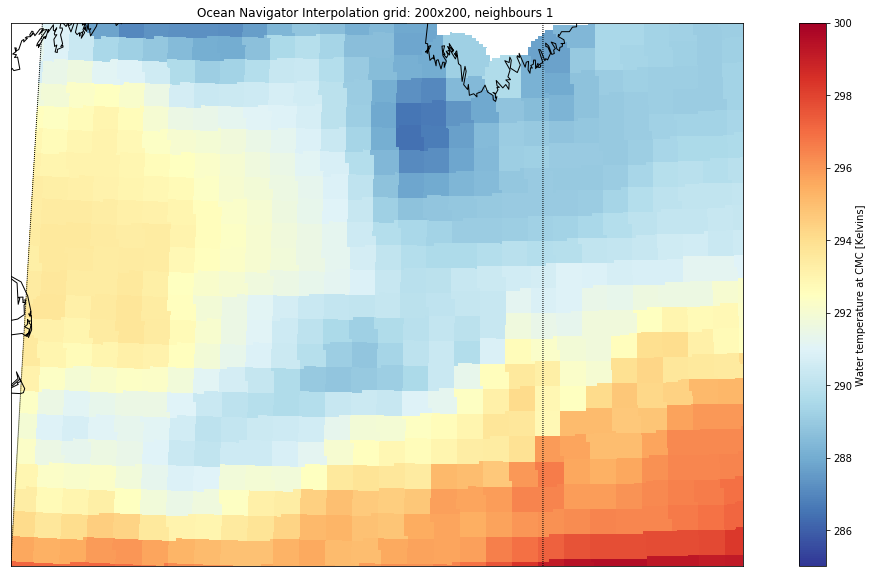

In [14]:
n=200
neighbs = [50, 20, 10,5,1]

lonsi = np.linspace(llcrlon,urcrlon,num=n)
latsi = np.linspace(llcrlat,urcrlat,num=n)
lonsi, latsi = np.meshgrid(lonsi, latsi)
for ne in neighbs:    
    res = resample(lat,lon, latsi, lonsi, temp, neighbours=ne)
    title = 'Ocean Navigator Interpolation grid: {}x{}, neighbours {} '.format(n,n, ne)
    fig = plot(res, lonsi, latsi, title)

No impact unluess number of grid points is really small (~1)

## 3. Nearest neighbour interpolation

Nearest neighbour interpolation, radius=25000, neighbours=10

Iterate through grid sizes

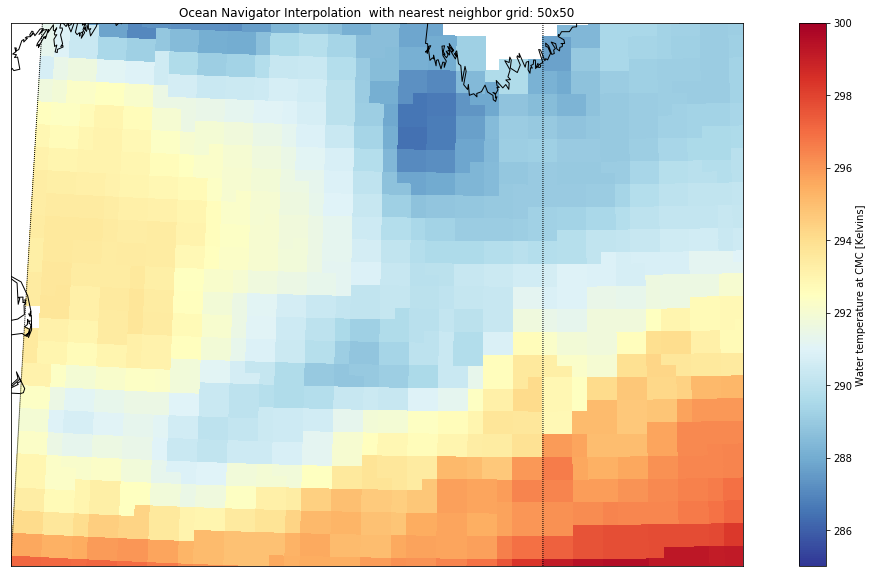

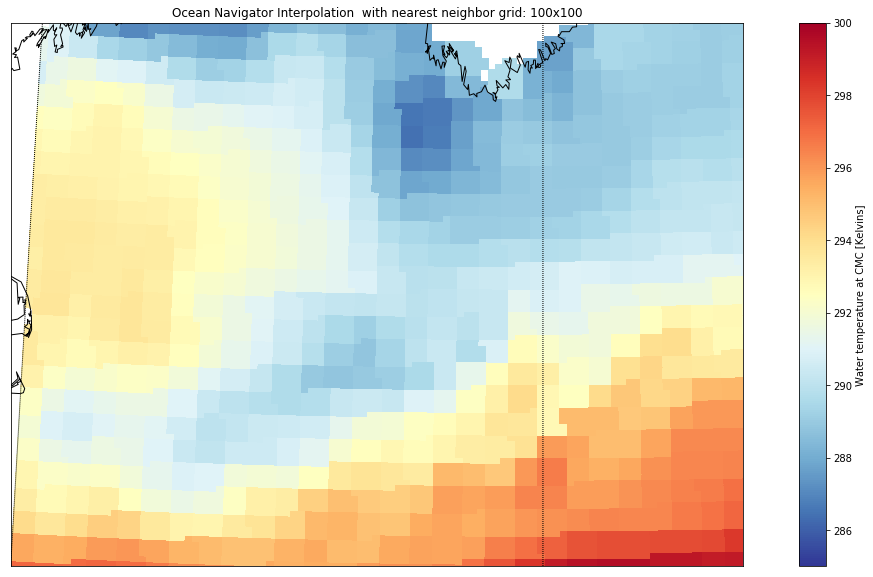

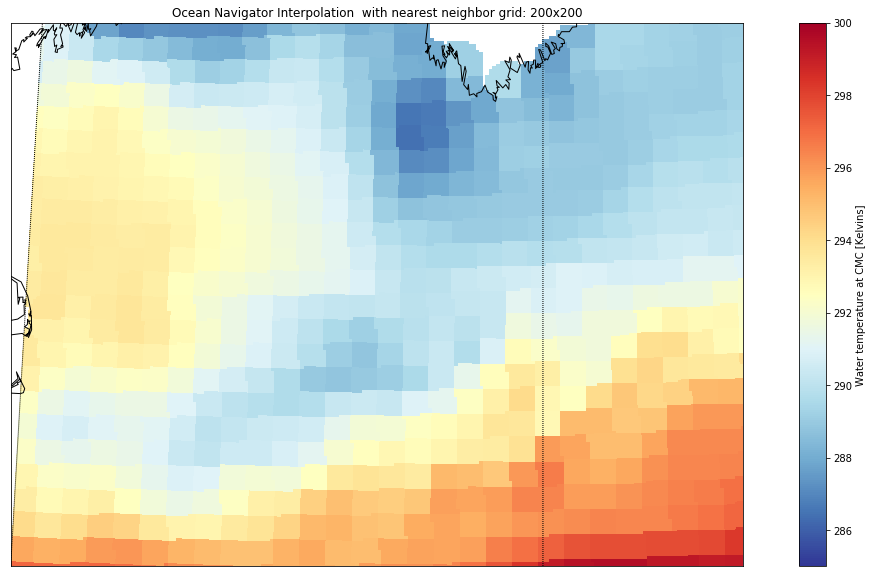

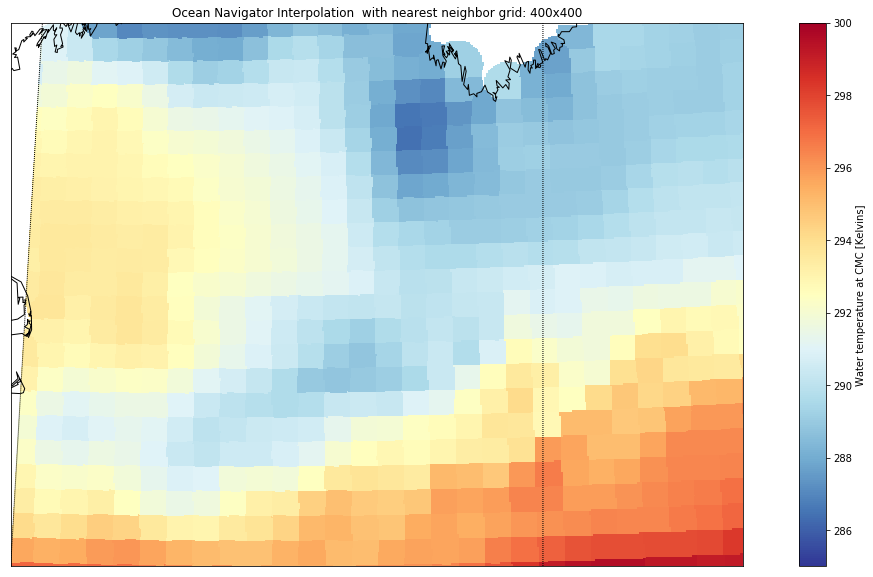

In [15]:
ns = [50,100, 200, 400]
radius=20000
for n in ns:
    lonsi = np.linspace(llcrlon,urcrlon,num=n)
    latsi = np.linspace(llcrlat,urcrlat,num=n)

    lonsi, latsi = np.meshgrid(lonsi, latsi)
    res = resample(lat,lon, latsi, lonsi, temp,method='nn', radius_of_influence=radius)
    title = 'Ocean Navigator Interpolation  with nearest neighbor grid: {}x{}'.format(n,n)
    fig = plot(res, lonsi, latsi, title)

Looks very gridded, no matter the grid size

## 4. Bilinear interpolation

Change grid size with bilinear interpolation, radius=25000

/home/nsoontiens/anaconda3/envs/ocn_nav/lib/python2.7/site-packages/pyresample/kd_tree.py:393: UserWarning: Possible more than 4 neighbours within 25000 m for some data points
  (neighbours, radius_of_influence))


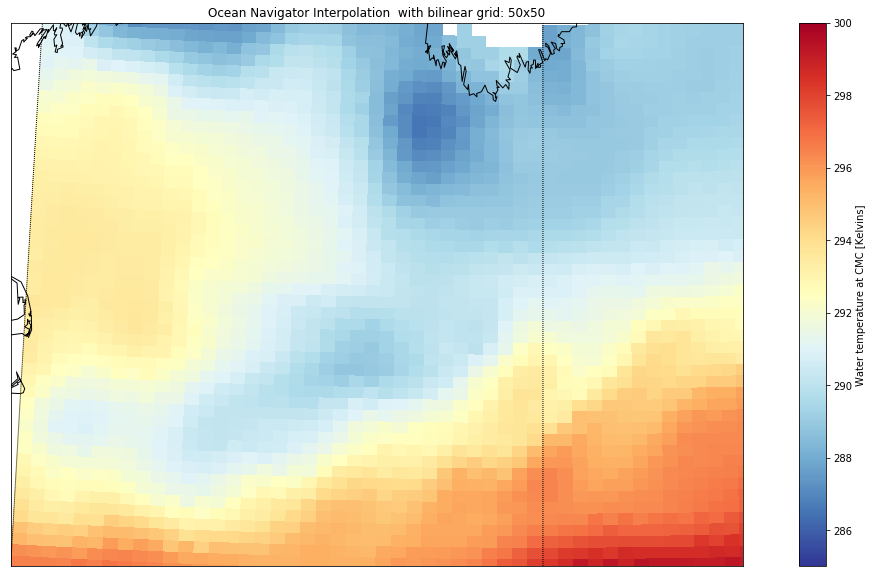

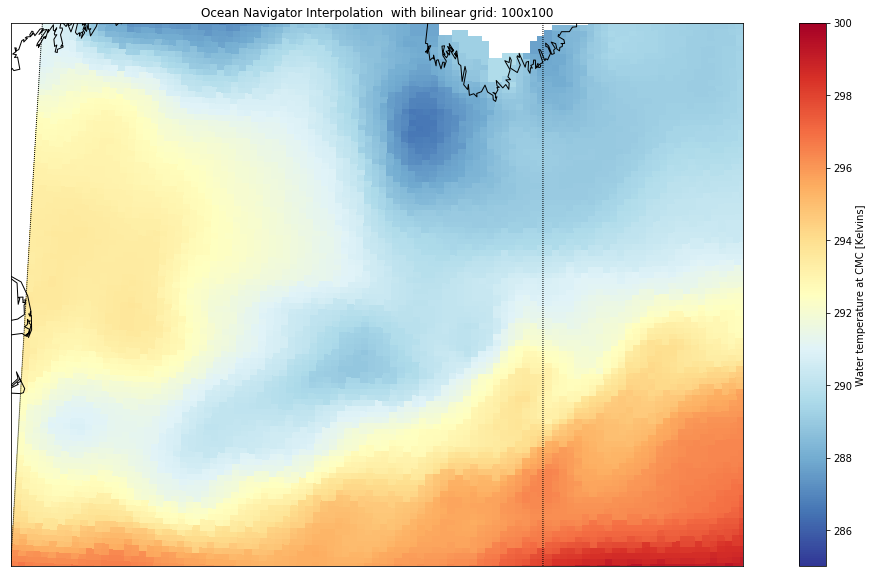

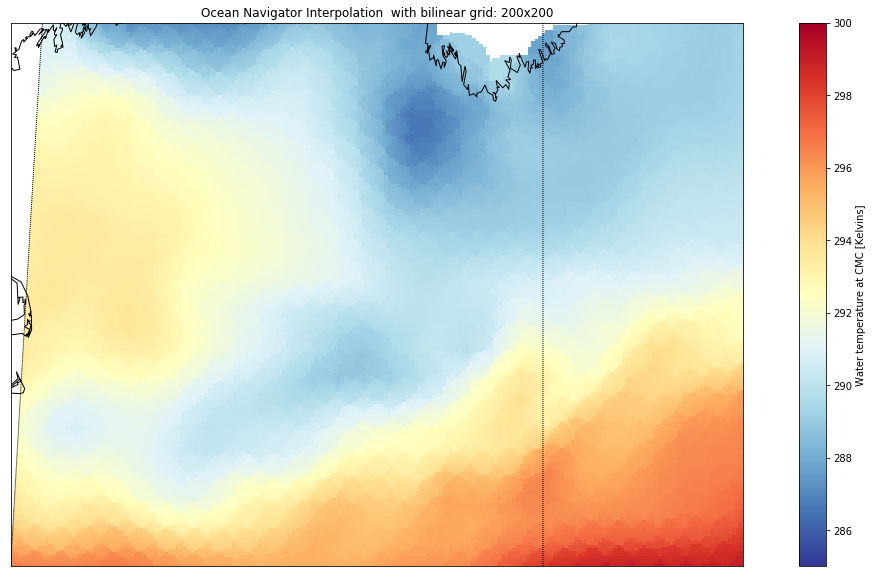

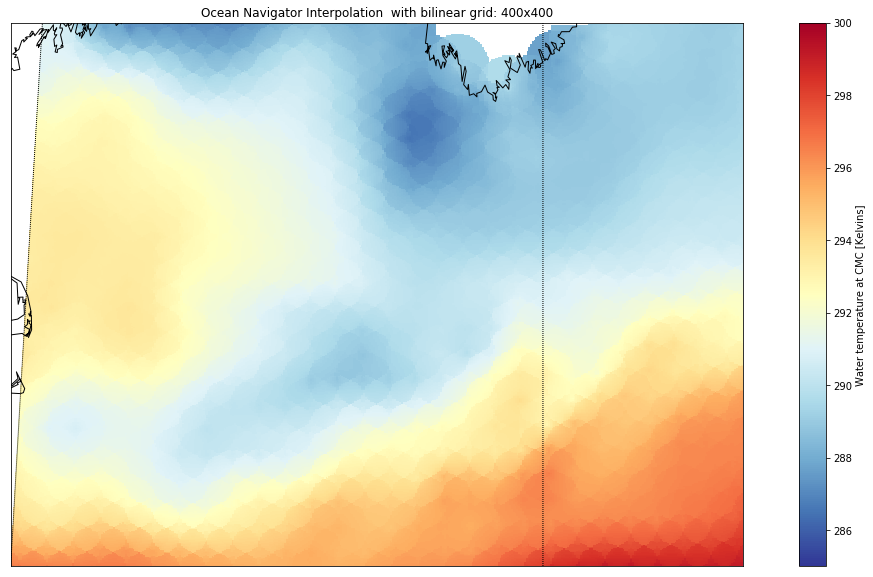

In [16]:
ns = [50,100, 200, 400]
radius=25000
for n in ns:
    lonsi = np.linspace(llcrlon,urcrlon,num=n)
    latsi = np.linspace(llcrlat,urcrlat,num=n)

    lonsi, latsi = np.meshgrid(lonsi, latsi)
    res = resample(lat,lon, latsi, lonsi, temp,method='bilinear',  radius_of_influence=radius)
    title = 'Ocean Navigator Interpolation  with bilinear grid: {}x{}'.format(n,n)
    fig = plot(res, lonsi, latsi, title)

## 5. Imshow Smoothing
Allow imshow to take care of the smooothing, after typcial Ocean Navigator interpolation

Small grid: (50x50), radius=25000, neighbours=10, method=inv_sqare

In [17]:
def plot_imshow(field, lon, lat,title, method='bilinear'):
    fig,ax=plt.subplots(1,1,figsize=(20,10))
    llcrlon,llcrlat,urcrlon,urcrlat=-70,40,-63,44
    bmap = Basemap(llcrnrlon=llcrlon,llcrnrlat=llcrlat,urcrnrlon=urcrlon,urcrnrlat=urcrlat,
                resolution='i',projection='cass',lon_0=-65,lat_0=42,ax=ax)
    bmap.drawmeridians(np.arange(llcrlon,urcrlon,5.))
    bmap.drawparallels(np.arange(llcrlat,urcrlat,5.))
    bmap.drawcoastlines()
    x,y=bmap(lon, lat)
    mesh=bmap.imshow(field,vmin=285,vmax=300,cmap='RdYlBu_r', interpolation=method)
    cbar=plt.colorbar(mesh, ax=ax)
    cbar.set_label('{} [{}]'.format(f.variables['votemper'].long_name,
                                    f.variables['votemper'].units))
    ax.set_title(title)
    return fig

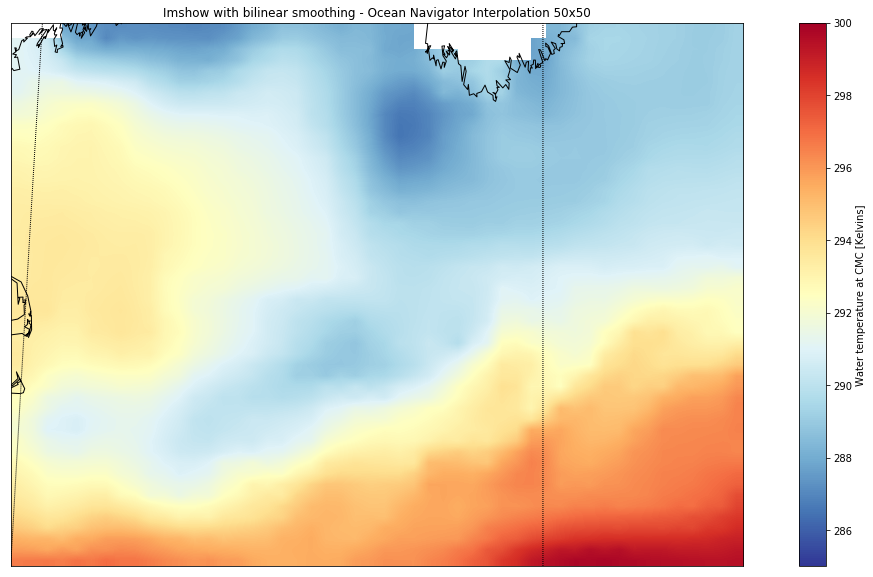

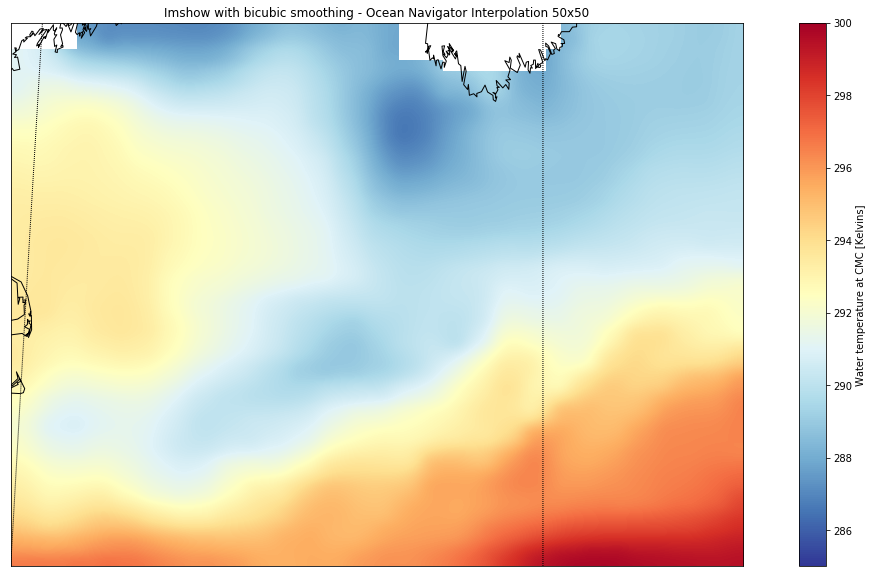

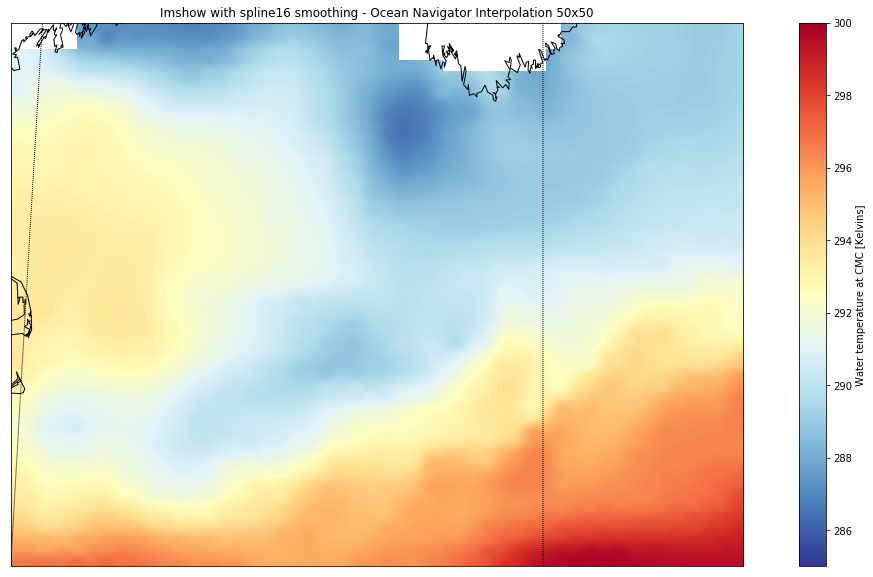

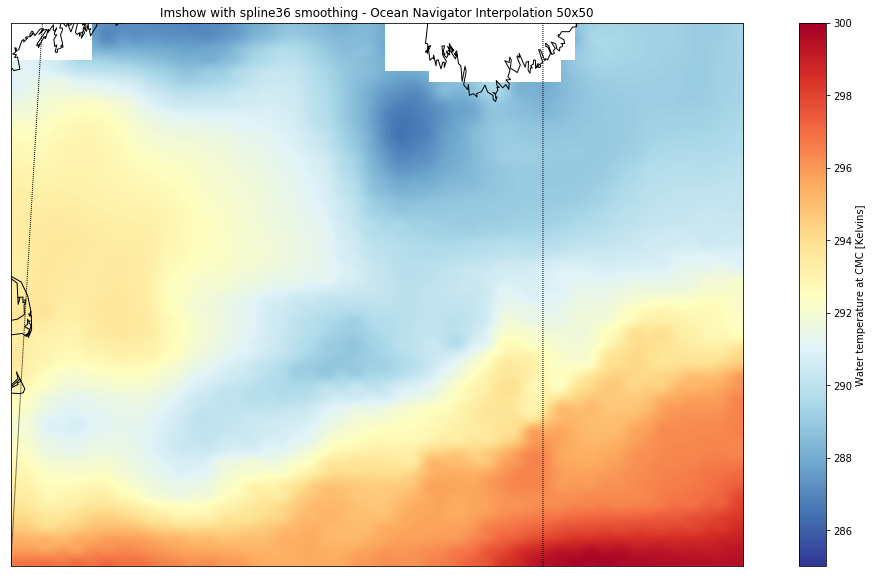

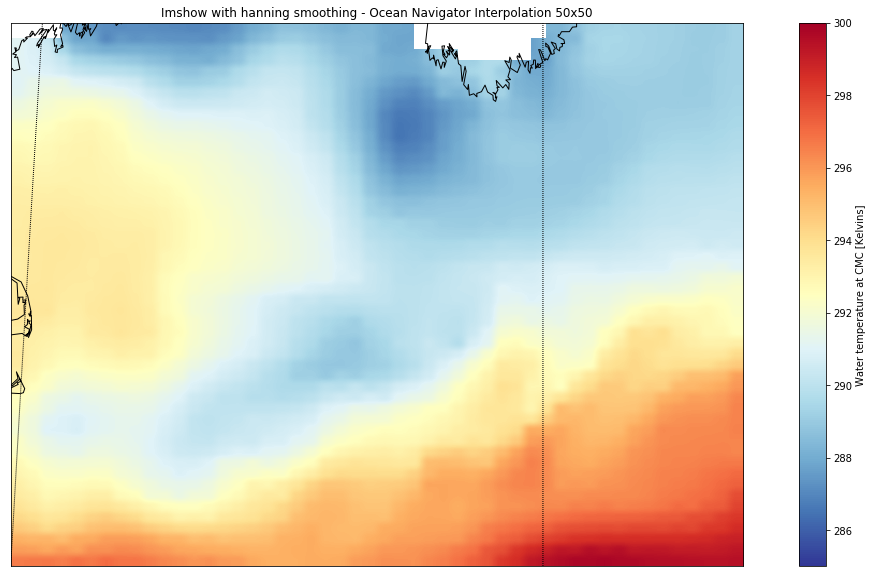

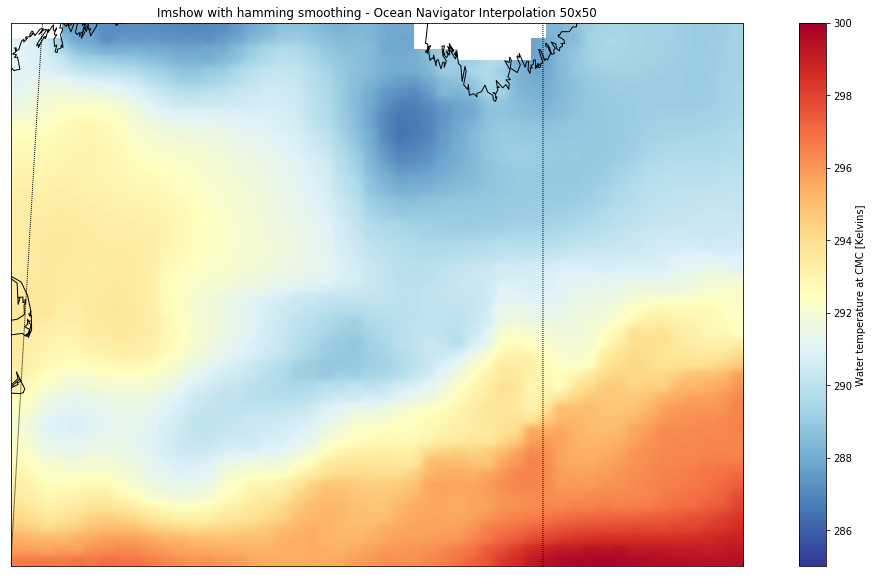

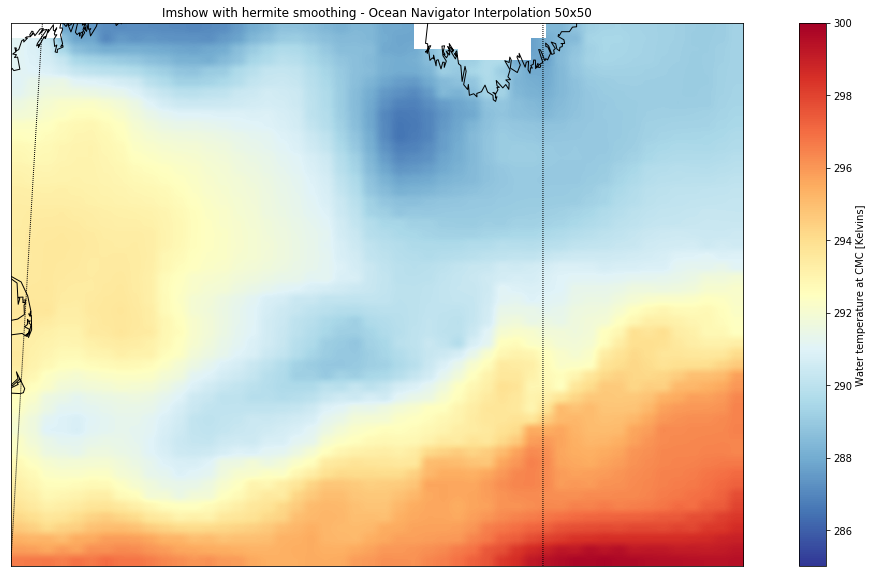

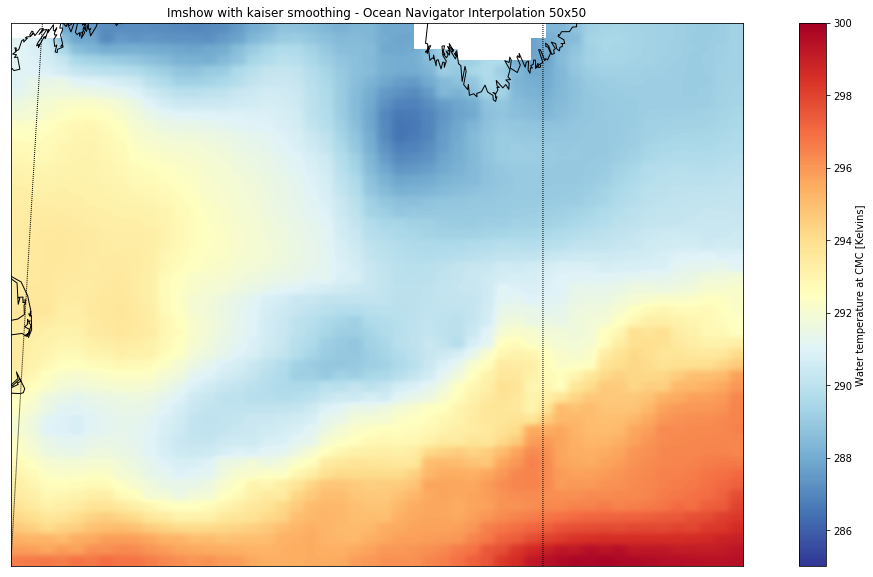

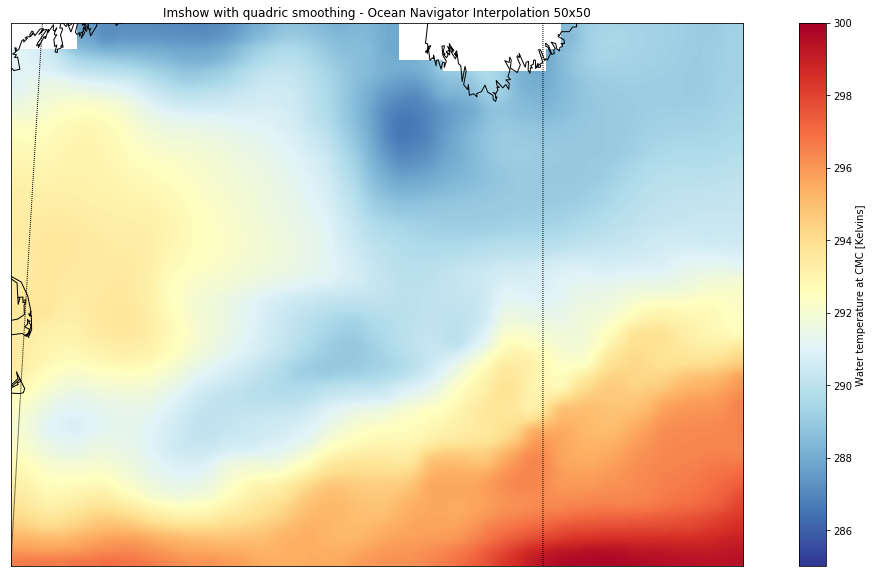

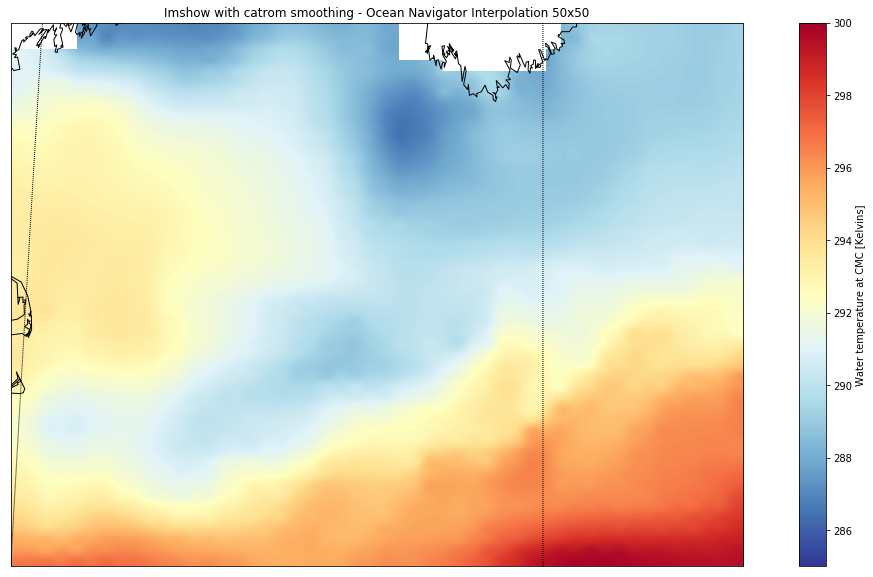

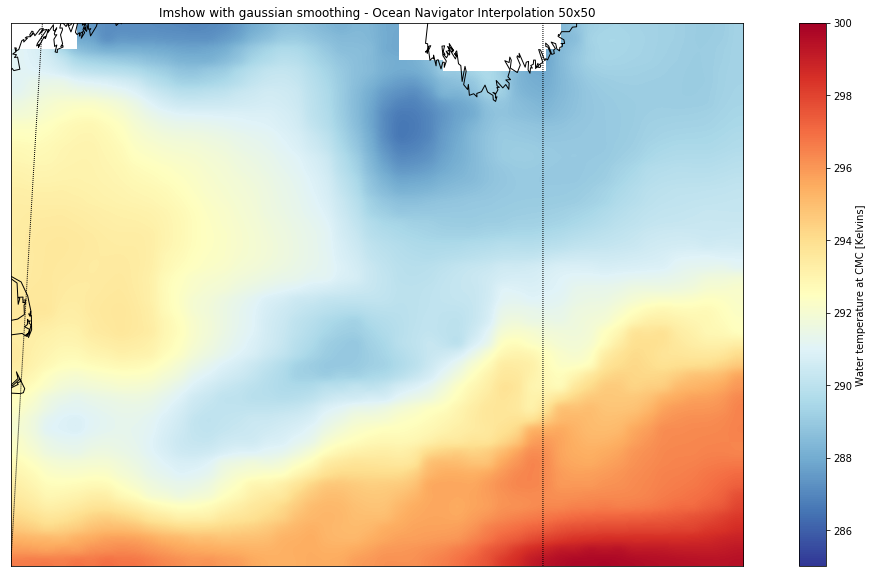

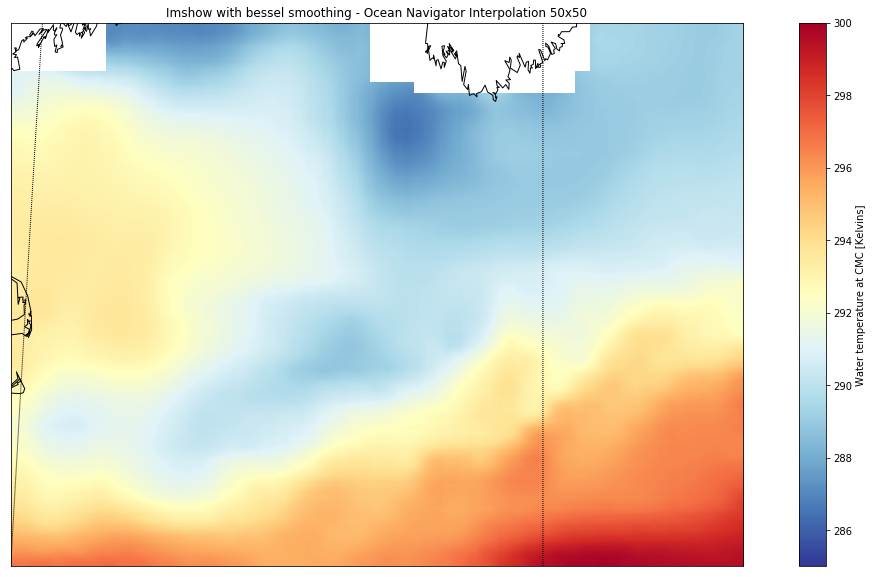

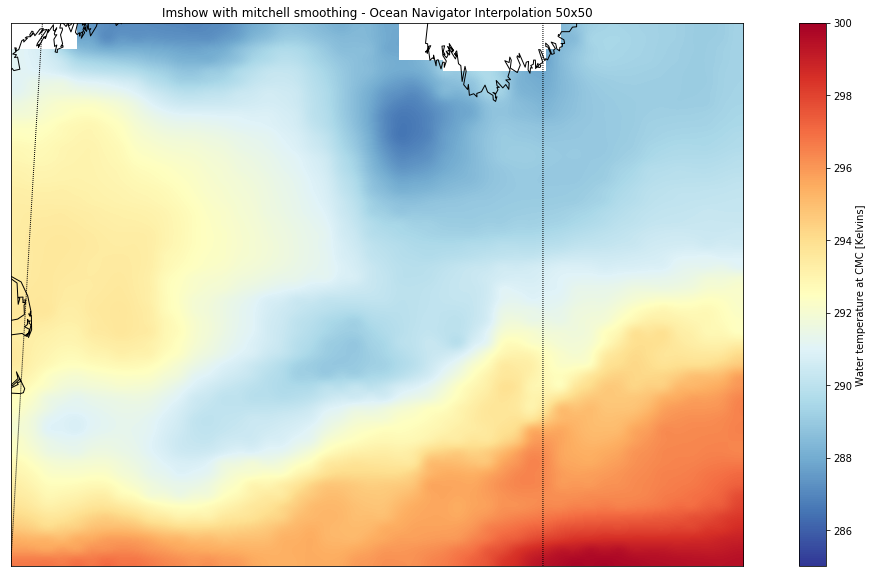

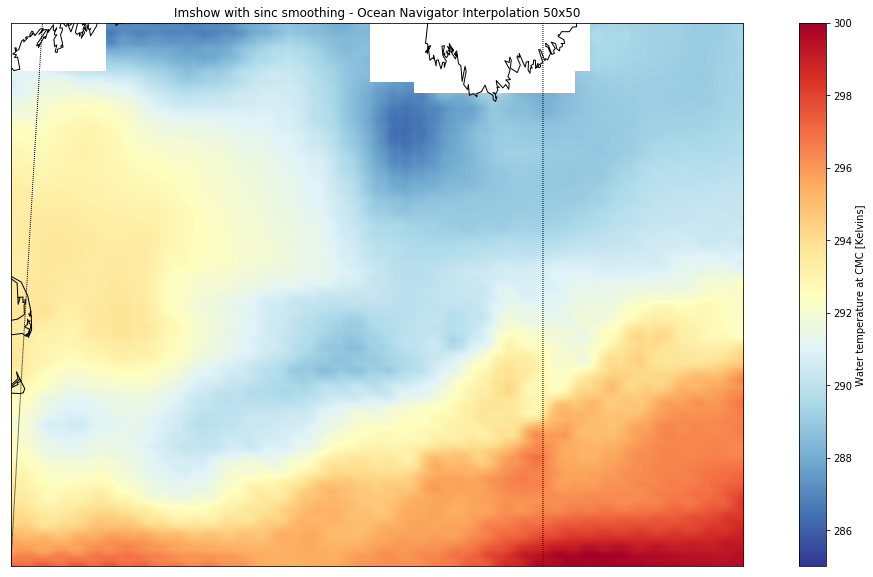

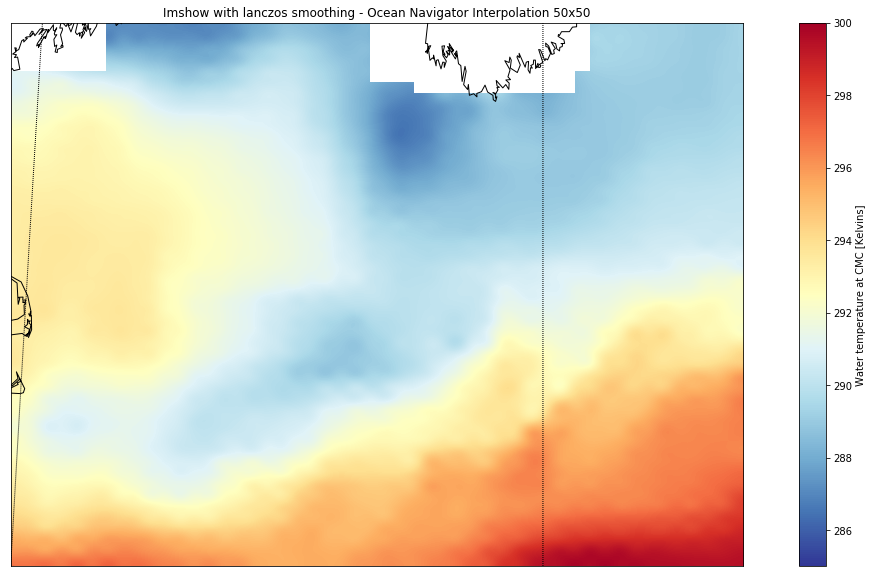

In [18]:
ms = ['bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 
      'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
n=50
lonsi = np.linspace(llcrlon,urcrlon,num=n)
latsi = np.linspace(llcrlat,urcrlat,num=n)

lonsi, latsi = np.meshgrid(lonsi, latsi)
res = resample(lat,lon, latsi, lonsi, temp)
    
for m in ms:
    title = 'Imshow with {} smoothing - Ocean Navigator Interpolation {}x{}'.format(m,n,n)
    fig = plot_imshow(res, lonsi, latsi, title, method=m)

# Conclusions
* Neighbours has no almost effect although there is a balance between # of neighbours and radius. # neighbours could be too small for a large radius. Very small values of # neighbours (~1) impacts visualization
* Radius determines size of the plotted circles. Above a certain value, this parameter has no impact. If it is too small quality degrades.
* Size of interpolated grid - for small grid sizes (<200x200), this parameter impacts visualization. Circular results for large grids, square or grid boxes for smaller grids. 
* Hypothesis: Overlapping circles problem occurs when interpolated is grid much larger than original grid. 
* Imshow with bicubic smoothing and most Ocean Navigator interpolations on small grid looks pretty good. Gaussian and quadric are also good. It doesn't seem to be too slow either.
* Imshow smoothing did not work will with Ocean Navigator nearest neighbour interpolation or with any interpolation that resulted in circles (example 400x400 grid with inv_square)
* Suggested Solution: At high zoom levels, reduce size of interpolated grid (50 x 50 works) and use imshow bicubic (or quadric or gaussian) interpolation